In [1]:
# !pip install gensim
# !pip install pyldavis
# !python -m spacy download en

### Introduction
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

In [2]:
! pip install --upgrade pip
! pip install --upgrade ipykernel
! pip install --upgrade nbdime
! pip install jupyterlab-git
! pip install bs4
! pip install contractions

     |████████████████████████████████| 1.5 MB 6.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
     |████████████████████████████████| 122 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 786 kB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 12.0 MB/s eta 0:00:01
  Attempting uninstall: ipython
    Found existing installation: ipython 7.19.0
    Uninstalling ipython-7.19.0:
      Successfully uninstalled ipython-7.19.0
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.1.1
    Uninstalling ipykernel-5.1.1:
      Successfully uninstalled ipykernel-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which i

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os
import json
import re
import gzip

In [4]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')

from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

import spacy
import gensim
from gensim import corpora

import contractions
from bs4 import BeautifulSoup    
import pyLDAvis
import pyLDAvis.gensim

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# os.getcwd()
# os.listdir('/kaggle/input/amazon-automotive-reviews')

## Data Dictionary 
# * **reviewerID –** ID of the reviewer
# * **asin –** ID of the product
# * **reviewerName –** name of the reviewer
# * **helpful –** helpfulness rating of the review, e.g. 2/3
# * **reviewText –** text of the review
# * **overall –** rating of the product
# * **summary –** summary of the review
# * **unixReviewTime –** time of the review (unix time)
# * **reviewTime –** time of the review (raw)

# raw_data = pd.read_json('/kaggle/input/amazon-automotive-reviews/Automotive_5.json', lines=True)
# print(raw_data.shape)
# raw_data.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
docs_raw = newsgroups.data
print(len(docs_raw))

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11314


In [7]:
print(newsgroups.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
newsgroups.keys()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [9]:
cnt=0
for text in docs_raw:
    if cnt==5:
        break
    print(text)
    print("-"*100)
    print("\n")
    cnt+=1 

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
----------------------------------------------------------------------------------------------------


A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
import numpy as np
list(zip(np.arange(len(newsgroups.target_names)),[i for i in newsgroups.target_names]))

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 'alt.atheism'),
 (1, 'comp.graphics'),
 (2, 'comp.os.ms-windows.misc'),
 (3, 'comp.sys.ibm.pc.hardware'),
 (4, 'comp.sys.mac.hardware'),
 (5, 'comp.windows.x'),
 (6, 'misc.forsale'),
 (7, 'rec.autos'),
 (8, 'rec.motorcycles'),
 (9, 'rec.sport.baseball'),
 (10, 'rec.sport.hockey'),
 (11, 'sci.crypt'),
 (12, 'sci.electronics'),
 (13, 'sci.med'),
 (14, 'sci.space'),
 (15, 'soc.religion.christian'),
 (16, 'talk.politics.guns'),
 (17, 'talk.politics.mideast'),
 (18, 'talk.politics.misc'),
 (19, 'talk.religion.misc')]

In [11]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
  
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


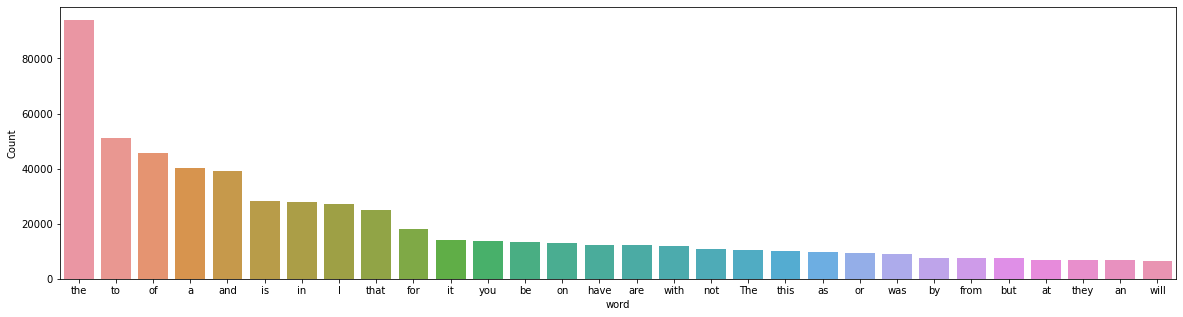

In [12]:
freq_words(docs_raw)

### Data Pre-processing:

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data

We have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words.

In [13]:
data=pd.DataFrame(docs_raw)
data=data.sample(frac=1) # Shuffling the data
data.reset_index(inplace=True)
data.columns=['ID','Text']
print(data.shape)
data.head(3)

(11314, 2)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Text
0,10744,"Bully, Them; Bludgeon Them, Bury Them.\n-- \nDave Feustel N9MYI <feustel@netcom.com>"
1,11075,"\nI bought a Bernoulli 90pro drive last year after comparing it with lots of\n diffrent storage solutions,\nOPTICAL drives are SLOW, very slow compared to 13 to 19ms access of Bernoulli.\n\nSince ..."
2,5874,"\n\noh, i see. electricity is a natural right & our wonderful government\nwould -never- cut off the power to the people they were besieging.\nare you really this dumb, or just acting like it for t..."


In [14]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
data['Text'] = data['Text'].apply(lambda x: strip_html(x))
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Text
0,10744,"Bully, Them; Bludgeon Them, Bury Them.\n-- \nDave Feustel N9MYI"
1,11075,"\nI bought a Bernoulli 90pro drive last year after comparing it with lots of\n diffrent storage solutions,\nOPTICAL drives are SLOW, very slow compared to 13 to 19ms access of Bernoulli.\n\nSince ..."
2,5874,"\n\noh, i see. electricity is a natural right & our wonderful government\nwould -never- cut off the power to the people they were besieging.\nare you really this dumb, or just acting like it for t..."
3,4518,"Hi,\n\nI'm looking for a X-Windows tool that can display data (in a\n2D plot) in real time with a couple different signals. \nAnybody know of such a gem? Please Email me as I do not read\nthis g..."
4,10981,"Hello everybody,\n\nI hope that I insert the right Options, so that my question is only\ndistributed through out Germany, because my question is more or less\ncountry dependend.\n\nNow the questio..."


In [16]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
data['Text'] = data['Text'].apply(lambda x: replace_contractions(x))
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Text
0,10744,"Bully, Them; Bludgeon Them, Bury Them.\n-- \nDave Feustel N9MYI"
1,11075,"\nI bought a Bernoulli 90pro drive last year after comparing it with lots of\n diffrent storage solutions,\nOPTICAL drives are SLOW, very slow compared to 13 to 19ms access of Bernoulli.\n\nSince ..."
2,5874,"\n\noh, i see. electricity is a natural right & our wonderful government\nwould -never- cut off the power to the people they were besieging.\nare you really this dumb, or just acting like it for t..."
3,4518,"Hi,\n\nI am looking for a X-Windows tool that can display data (in a\n2D plot) in real time with a couple different signals. \nAnybody know of such a gem? Please Email me as I do not read\nthis ..."
4,10981,"Hello everybody,\n\nI hope that I insert the right Options, so that my question is only\ndistributed through out Germany, because my question is more or less\ncountry dependend.\n\nNow the questio..."


In [18]:
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
data['Text'] = data['Text'].apply(lambda x: remove_numbers(x))
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Text
0,10744,"Bully, Them; Bludgeon Them, Bury Them.\n-- \nDave Feustel NMYI"
1,11075,"\nI bought a Bernoulli pro drive last year after comparing it with lots of\n diffrent storage solutions,\nOPTICAL drives are SLOW, very slow compared to to ms access of Bernoulli.\n\nSince I need..."
2,5874,"\n\noh, i see. electricity is a natural right & our wonderful government\nwould -never- cut off the power to the people they were besieging.\nare you really this dumb, or just acting like it for t..."
3,4518,"Hi,\n\nI am looking for a X-Windows tool that can display data (in a\nD plot) in real time with a couple different signals. \nAnybody know of such a gem? Please Email me as I do not read\nthis g..."
4,10981,"Hello everybody,\n\nI hope that I insert the right Options, so that my question is only\ndistributed through out Germany, because my question is more or less\ncountry dependend.\n\nNow the questio..."


In [20]:
data['Text'] = data.apply(lambda row: nltk.word_tokenize(row['Text']), axis=1) # Tokenization of data

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
data.head()# Look at how tokenized data looks.

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Text
0,10744,"[Bully, ,, Them, ;, Bludgeon, Them, ,, Bury, Them, ., --, Dave, Feustel, NMYI]"
1,11075,"[I, bought, a, Bernoulli, pro, drive, last, year, after, comparing, it, with, lots, of, diffrent, storage, solutions, ,, OPTICAL, drives, are, SLOW, ,, very, slow, compared, to, to, ms, access, of..."
2,5874,"[oh, ,, i, see, ., electricity, is, a, natural, right, &, our, wonderful, government, would, -never-, cut, off, the, power, to, the, people, they, were, besieging, ., are, you, really, this, dumb,..."
3,4518,"[Hi, ,, I, am, looking, for, a, X-Windows, tool, that, can, display, data, (, in, a, D, plot, ), in, real, time, with, a, couple, different, signals, ., Anybody, know, of, such, a, gem, ?, Please,..."
4,10981,"[Hello, everybody, ,, I, hope, that, I, insert, the, right, Options, ,, so, that, my, question, is, only, distributed, through, out, Germany, ,, because, my, question, is, more, or, less, country,..."


In [22]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')
stop_words=list(set(stop_words))
print(len(stop_words))
print(stop_words)

179
['same', 'by', 'just', 'few', "hasn't", 'to', 'yourselves', 'against', 'mustn', 'yourself', 'has', 'there', 'whom', 'had', 'only', "couldn't", 'y', 'was', 'than', 'o', "aren't", 'didn', "mightn't", 'for', 'won', 'your', 'have', 'as', 'and', 'or', 'why', 'him', 'once', 'll', 'but', 'out', 'needn', 'hadn', 'its', 'above', 'those', 'from', 'down', 'the', 'my', 'up', 'isn', 'this', 's', 'in', 'shan', 'wasn', 'that', "won't", 'weren', 'of', 'do', 'hers', 'are', 'no', "it's", 'through', 'their', 've', "you'll", 'hasn', 'will', "isn't", 'his', "you'd", 'most', 'they', 'where', "wasn't", 'me', 'm', 'own', 'can', 'nor', 'if', 'theirs', 'below', 'ours', "shouldn't", 'is', 'over', 'both', 'further', 'which', "you've", 'how', "that'll", 'he', 'while', 'yours', 'our', 'any', 'herself', 'being', 'doing', 'myself', 'until', 'when', "haven't", 'mightn', 'very', 'not', 'between', 'am', 't', 'should', 'into', 'aren', 'couldn', 'shouldn', 'ourselves', 'all', "hadn't", 'then', "shan't", 'you', 'other'

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
import re, string, unicodedata   

lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
        new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
data['Text'] = data.apply(lambda row: normalize(row['Text']), axis=1)
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Text
0,10744,bully bludgeon bury dave feustel nmyi
1,11075,buy bernoulli pro drive last year compare lot diffrent storage solutions optical drive slow slow compare ms access bernoulli since need additinol online storage rather backup archiev e disk choose...
2,5874,oh see electricity natural right wonderful government would never cut power people besiege really dumb act like sake argument jason
3,4518,hi look xwindows tool display data plot real time couple different signal anybody know gem please email read group often
4,10981,hello everybody hope insert right options question distribute germany question less country dependend question anybody tell course ftpsitearchie whatever din fonts x available look fonts hold spec...


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


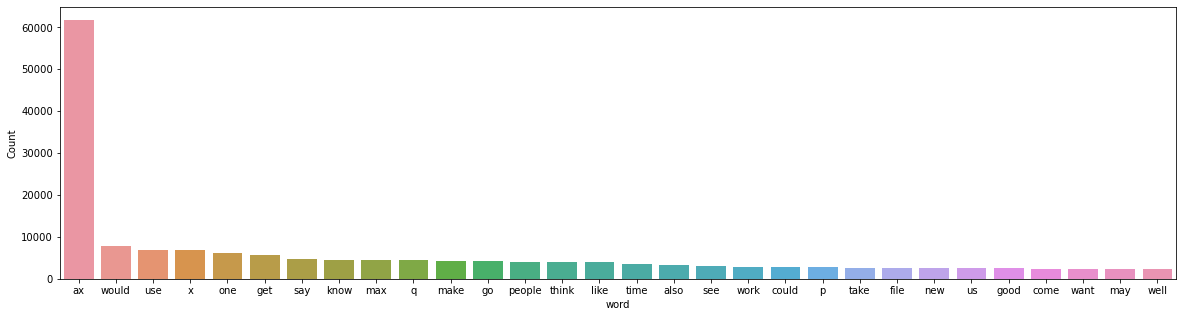

In [26]:
freq_words(data['Text'])

In [27]:
# remove short words (length < 2)
data['Text'] = data['Text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Text
0,10744,bully bludgeon bury dave feustel nmyi
1,11075,buy bernoulli pro drive last year compare lot diffrent storage solutions optical drive slow slow compare ms access bernoulli since need additinol online storage rather backup archiev disk choose b...
2,5874,oh see electricity natural right wonderful government would never cut power people besiege really dumb act like sake argument jason
3,4518,hi look xwindows tool display data plot real time couple different signal anybody know gem please email read group often
4,10981,hello everybody hope insert right options question distribute germany question less country dependend question anybody tell course ftpsitearchie whatever din fonts available look fonts hold specif...


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


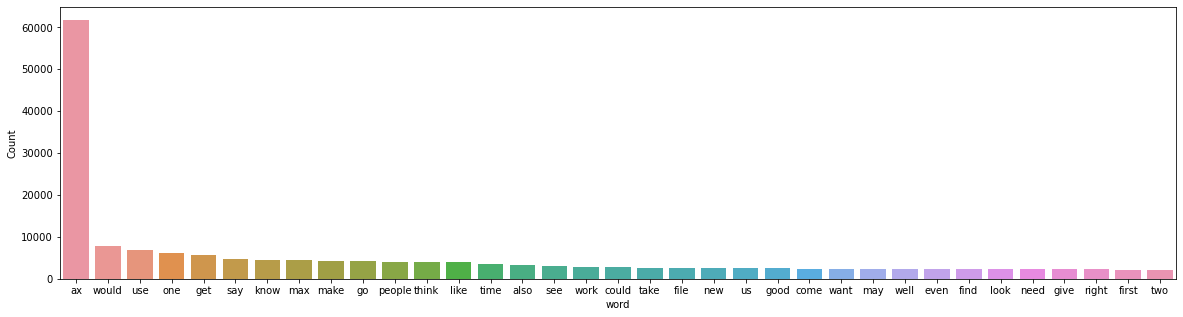

In [28]:
freq_words(data['Text'], 35)

In [29]:
# nlp = spacy.load('en', disable=['parser', 'ner'])

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
word_tokens = data.apply(lambda row: nltk.word_tokenize(row['Text']), axis=1) # Tokenization of data

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
word_tokens[:5]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                                                                                                                                                               [bully, bludgeon, bury, dave, feustel, nmyi]
1    [buy, bernoulli, pro, drive, last, year, compare, lot, diffrent, storage, solutions, optical, drive, slow, slow, compare, ms, access, bernoulli, since, need, additinol, online, storage, rather, ba...
2                                                   [oh, see, electricity, natural, right, wonderful, government, would, never, cut, power, people, besiege, really, dumb, act, like, sake, argument, jason]
3                                                              [hi, look, xwindows, tool, display, data, plot, real, time, couple, different, signal, anybody, know, gem, please, email, read, group, often]
4    [hello, everybody, hope, insert, right, options, question, distribute, germany, question, less, country, dependend, question, anybody, tell, course, ftpsitearchie, whatever, d

In [32]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(word_tokens)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
cnt=0
for i,j in dictionary.items():
    if(cnt==5):
        break
    print(i,j)
    cnt+=1

0 bludgeon
1 bully
2 bury
3 dave
4 feustel


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in word_tokens]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# ?LDA

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,id2word=dictionary,num_topics=10,random_state=11)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
lda_model.print_topics()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.006*"would" + 0.006*"go" + 0.006*"one" + 0.006*"say" + 0.005*"game" + 0.005*"people" + 0.005*"think" + 0.005*"make" + 0.005*"team" + 0.004*"get"'),
 (1,
  '0.014*"use" + 0.014*"db" + 0.012*"drive" + 0.007*"card" + 0.007*"get" + 0.007*"one" + 0.007*"would" + 0.006*"windows" + 0.006*"problem" + 0.006*"work"'),
 (2,
  '0.007*"use" + 0.005*"space" + 0.005*"program" + 0.005*"key" + 0.005*"government" + 0.004*"would" + 0.004*"state" + 0.004*"information" + 0.004*"post" + 0.004*"encryption"'),
 (3,
  '0.011*"launch" + 0.008*"db" + 0.005*"use" + 0.005*"space" + 0.005*"wire" + 0.005*"car" + 0.004*"would" + 0.004*"one" + 0.004*"engine" + 0.003*"power"'),
 (4,
  '0.012*"use" + 0.008*"get" + 0.008*"key" + 0.007*"one" + 0.006*"also" + 0.005*"would" + 0.005*"like" + 0.005*"file" + 0.005*"scsi" + 0.004*"bite"'),
 (5,
  '0.016*"god" + 0.010*"say" + 0.010*"jesus" + 0.010*"one" + 0.008*"would" + 0.007*"people" + 0.007*"think" + 0.006*"believe" + 0.006*"make" + 0.005*"mean"'),
 (6,
  '0.015*"us

## Visualizing the models with pyLDAvis

* 1  Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lif,brt
* 2 By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 )
* 3 Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic
* 4 The red bars represent the frequency of a term in a given topic, (proportional to p(term | topic))
* 5 The blue bars represent a term's frequency across the entire corpus, (proportional to p(term))

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.094482  0.043030       1        1  22.492922
0      0.077704  0.067654       2        1  13.570953
2      0.076708 -0.028463       3        1  13.009897
5      0.064901  0.122022       4        1  10.054187
1      0.059738 -0.133271       5        1   9.377279
8     -0.509864 -0.018997       6        1   9.361196
6      0.066952 -0.106687       7        1   8.600956
4      0.062491 -0.102511       8        1   6.570861
3      0.023349 -0.016230       9        1   4.294757
9     -0.016461  0.173454      10        1   2.666992, topic_info=         Term          Freq         Total Category  logprob  loglift
10448      ax  77807.000000  77807.000000  Default  30.0000  30.0000
3263      max   5703.000000   5703.000000  Default  29.0000  29.0000
8941       db   2024.000000   2024.000000  Default  28.0000  28.0000
127       god   2081.000000   2081.000000  Default  27.0000  27.0000
44        use   7119.000000   7119.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
58     people    129.963975   4563.139191  Topic10  -5.4805   0.0657
4562   jewish     70.382264    383.260250  Topic10  -6.0938   1.9294
177       one     92.960832   6819.288805  Topic10  -5.8156  -0.6711
1557   source     71.300234   1021.595594  Topic10  -6.0808   0.9620
146       say     70.466762   5253.339125  Topic10  -6.0926  -0.6873

[875 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
6842       1  0.041615     __
6842       2  0.048551     __
6842       5  0.263565     __
6842       6  0.020808     __
6842       7  0.006936     __
...      ...       ...    ...
629       10  0.017524  years
16169      1  0.970220  yeast
16169      7  0.017325  yeast
12388      6  0.976839     ze
11538      6  0.986441    zei

[3657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 3, 6, 2, 9, 7, 5, 4, 10])

In [40]:
# Let’s now put the models to work and transform unseen documents to their topic distribution:

# Each bubble on the left-hand side plot represents a topic. 
# The larger the bubble, the more prevalent is that topic.

# A good topic model will have fairly big, non-overlapping bubbles scattered 
# throughout the chart instead of being clustered in one quadrant.

# A model with too many topics, will typically have many overlaps, small sized 
# bubbles clustered in one region of the chart.

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Reference Links - 
1. https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
2. https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/